In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import finufft
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
from kernels.matern import Matern
import math
from torch.profiler import profile, record_function, ProfilerActivity
import pytorch_finufft.functional as pff
from typing import Dict, Optional, Callable, Tuple
from cg import ConjugateGradients, BatchConjugateGradients
from typing import Optional, Tuple, Dict
import pytorch_finufft.functional as pff
from cg import ConjugateGradients, BatchConjugateGradients
from efgpnd import ToeplitzND, compute_convolution_vector_vectorized_dD, _cmplx, nufft_var_est_nd, diag_sums_nd, efgp_nd, EFGPND, efgpnd_gradient_batched
import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


Generated 1000000 points with shape torch.Size([1000000, 2])
Using device: cpu


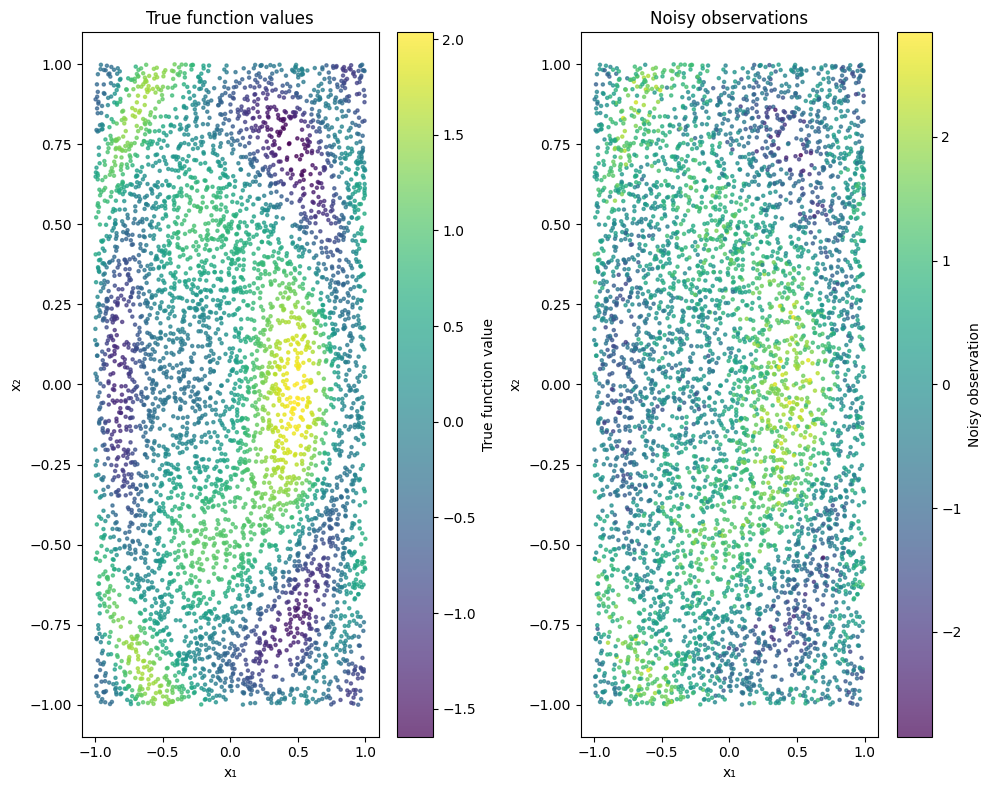

In [2]:
# --- Parameters ---
n = 1_000_000  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale = 0.3
true_variance = 1.0
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 for numerical stability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# --- Define the true function ---
def true_function(x):
    """
    A 2D function to generate synthetic data
    x: tensor of shape [n, 2]
    """
    # Example of a non-linear function with some interesting features
    return torch.sin(3 * x[:, 0]) * torch.cos(4 * x[:, 1]) + \
           0.5 * torch.exp(-((x[:, 0] - 0.3)**2 + (x[:, 1] + 0.3)**2) / 0.3) + \
           0.7 * torch.sin(2 * torch.pi * (x[:, 0]**2 + x[:, 1]**2))

# --- Generate target values with noise ---
# Compute true function values
f_true = true_function(x)

# Add Gaussian noise
noise = torch.randn(n, dtype=dtype, device=device) * math.sqrt(true_noise_variance)
y = f_true + noise

print(f"Generated {n} points with shape {x.shape}")
print(f"Using device: {device}")

# --- Visualize a subset of the data ---
if d == 2:
    plt.figure(figsize=(10, 8))
    
    # Plot the first 5000 points (or fewer if n is smaller)
    subset_size = min(5000, n)
    
    # Scatter plot colored by function value
    plt.subplot(1, 2, 1)
    sc = plt.scatter(x[:subset_size, 0].cpu(), x[:subset_size, 1].cpu(), 
                     c=f_true[:subset_size].cpu(), cmap='viridis', s=5, alpha=0.7)
    plt.colorbar(sc, label='True function value')
    plt.title('True function values')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    
    # Scatter plot colored by noisy observations
    plt.subplot(1, 2, 2)
    sc = plt.scatter(x[:subset_size, 0].cpu(), x[:subset_size, 1].cpu(), 
                     c=y[:subset_size].cpu(), cmap='viridis', s=5, alpha=0.7)
    plt.colorbar(sc, label='Noisy observation')
    plt.title('Noisy observations')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    
    plt.tight_layout()
    plt.show()


In [3]:


# # --- Parameters ---
# n = 10_000  # Number of points
# d = 2  # Dimensionality of the input space
# true_length_scale =0.1
# true_variance = 1
# true_noise_variance = 0.2
# dtype = torch.float64  # Use float64 as in the original example
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
# print(f"Using device: {device}")

# # --- Generate Input Points ---
# # Generate random points in d-dimensional space from -1 to 1
# x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1




In [4]:
# dat = torch.load('usa_temp_data.pt')
# x = dat['x']
# y= dat['y']
# d = 2

In [5]:
# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 100
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

In [6]:
# from gp_sampling import sample_gp_fast, sample_gp_matern

# # For squared exponential kernel
# samples_se = sample_gp_fast(
#     x,
#     length_scale=true_length_scale,
#     variance=true_variance,
#     noise_variance=true_noise_variance
# )
# # For Matern kernel
# samples_m32 = sample_gp_matern(
#     x,
#     nu=1.5,  # 3/2 Matern
#     length_scale=true_length_scale,
#     variance=true_variance,
#     noise_variance=true_noise_variance
# )

In [7]:
# dat = torch.load('world_temp_data.pt')

# # Standardize the data so that 90% of the data is within [-1, 1]^d
# print("Original data shape:", x.shape)

# # Calculate 5th and 95th percentiles for each dimension
# lower_percentile = torch.quantile(x, 0.05, dim=0)
# upper_percentile = torch.quantile(x, 0.95, dim=0)

# # Scale the data so that 5th to 95th percentile range maps to [-1, 1]
# # This ensures 90% of the data falls within [-1, 1]^d
# x_standardized = 2 * (x - lower_percentile) / (upper_percentile - lower_percentile) - 1

# # Verify the scaling worked correctly
# print("5th percentile after scaling:", torch.quantile(x_standardized, 0.05, dim=0))
# print("95th percentile after scaling:", torch.quantile(x_standardized, 0.95, dim=0))
# print("Min values after scaling:", x_standardized.min(dim=0).values)
# print("Max values after scaling:", x_standardized.max(dim=0).values)

# Replace the original data with the standardized version
# x = x_standardized


In [8]:
# y = samples_se

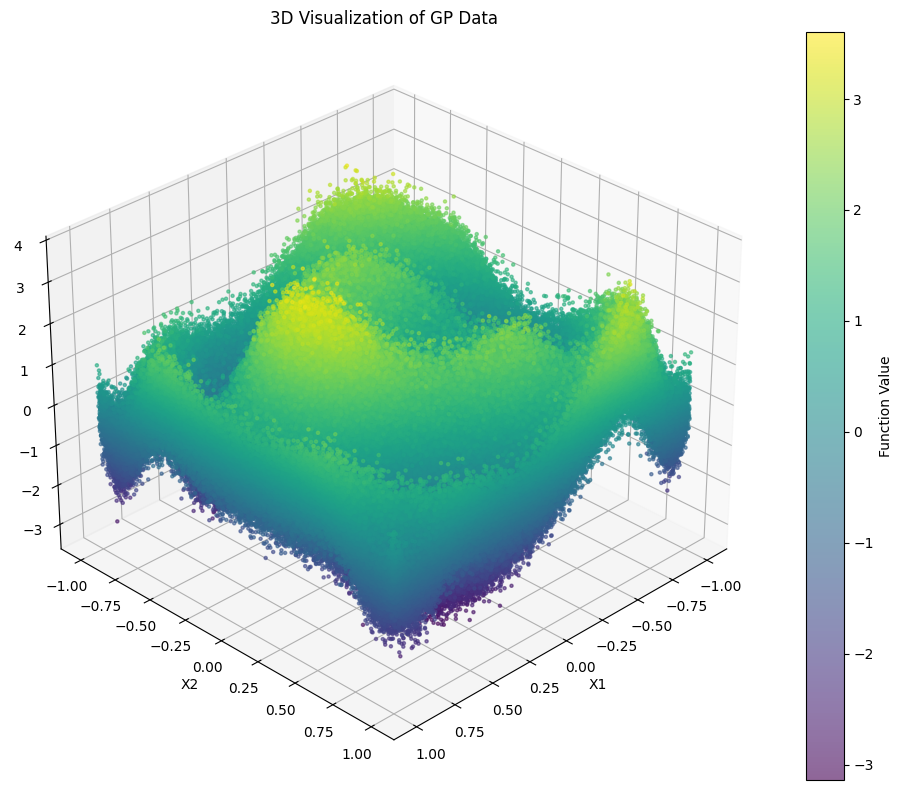

In [9]:
# Plot the data in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
scatter = ax.scatter(x[:, 0].cpu().numpy(), 
                    x[:, 1].cpu().numpy(), 
                    y.cpu().numpy(), 
                    c=y.cpu().numpy(), 
                    cmap='viridis', 
                    alpha=0.6,
                    s=5)  # smaller point size for better visibility

# Add a color bar
plt.colorbar(scatter, ax=ax, label='Function Value')

# Set labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

# Add a title
ax.set_title('3D Visualization of GP Data')

# Adjust the viewing angle for better perspective
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


In [10]:
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  


In [11]:
d= 2 
input_range = x1.max() - x0.min()
lengthscale = input_range * 0.1  # 10% of the input range
# kernel = SquaredExponential(dimension=d, lengthscale=lengthscale, variance=1)
kernel = SquaredExponential(dimension=d, lengthscale=0.5, variance=1)
# kernel = Matern(dimension=d, name='matern32', lengthscale=0.5, variance=1)
# Calculate lengthscale as a fraction of the input space range


init_kernel = kernel
sigmasq = torch.tensor(0.1)
EPSILON = 1e-4

In [12]:
x.shape

torch.Size([1000000, 2])

In [13]:
cg_tol = EPSILON 
J = 500

model = EFGPND(
    x        = x,               
    y        = y,               
    kernel   = kernel,
    sigmasq  = sigmasq,
    eps      = EPSILON,
    opts     = {
        "cg_tolerance"     : cg_tol,
        "early_stopping"   : True,
    },
)



In [14]:
torch.manual_seed(42)
print(f'init kernel: {kernel}')
kernel = init_kernel
kernel.lengthscale = 0.1
model = EFGPND(x, y, kernel, sigmasq, EPSILON).optimize_hyperparameters(
    epsilon_values       = [1e-4],
    trace_samples_values = [10],
    base_lr              = 0.001,
    max_iters            = 50,
    x0 = x0, x1 = x1,                    
)
print("final hyperparams",model.kernel.lengthscale,model.kernel.variance,model.sigmasq)




init kernel: dimension=2 lengthscale=0.5 variance=1.0 num_hypers=3 hypers=['lengthscale', 'variance']
Auto-scaled learning rate: 0.000010 (base_lr=0.001, n_samples=1000000)
[ε=0.0001 | J=10] iter   0  ℓ=0.1083  σ_f²=0.9681  σ_n²=13.72
grad: tensor([-8.0622e+04,  3.2711e+03, -4.9707e+06], dtype=torch.float64)
[ε=0.0001 | J=10] iter  10  ℓ=0.1619  σ_f²=0.7929  σ_n²=5.289e+05
grad: tensor([-0.0013,  0.0067,  0.0067], dtype=torch.float64)
[ε=0.0001 | J=10] iter  20  ℓ=0.2449  σ_f²=0.6575  σ_n²=2.298e+14
grad: tensor([-2.3971e-12,  1.5072e-11,  1.5406e-11], dtype=torch.float64)
[ε=0.0001 | J=10] iter  30  ℓ=0.2345  σ_f²=0.6424  σ_n²=0.0224
grad: tensor([7.7123e+03, 2.0451e+02, 5.6205e+05], dtype=torch.float64)
[ε=0.0001 | J=10] iter  40  ℓ=0.2606  σ_f²=0.5388  σ_n²=4.548e+14
grad: tensor([ 5.4646e+03,  1.3316e+04, -1.6287e+08], dtype=torch.float64)
└─ finished ε=0.0001, J=10 in 36.9s
final hyperparams 0.2514321013328843 0.5074340166919016 tensor(5.4917e+09, dtype=torch.float64)


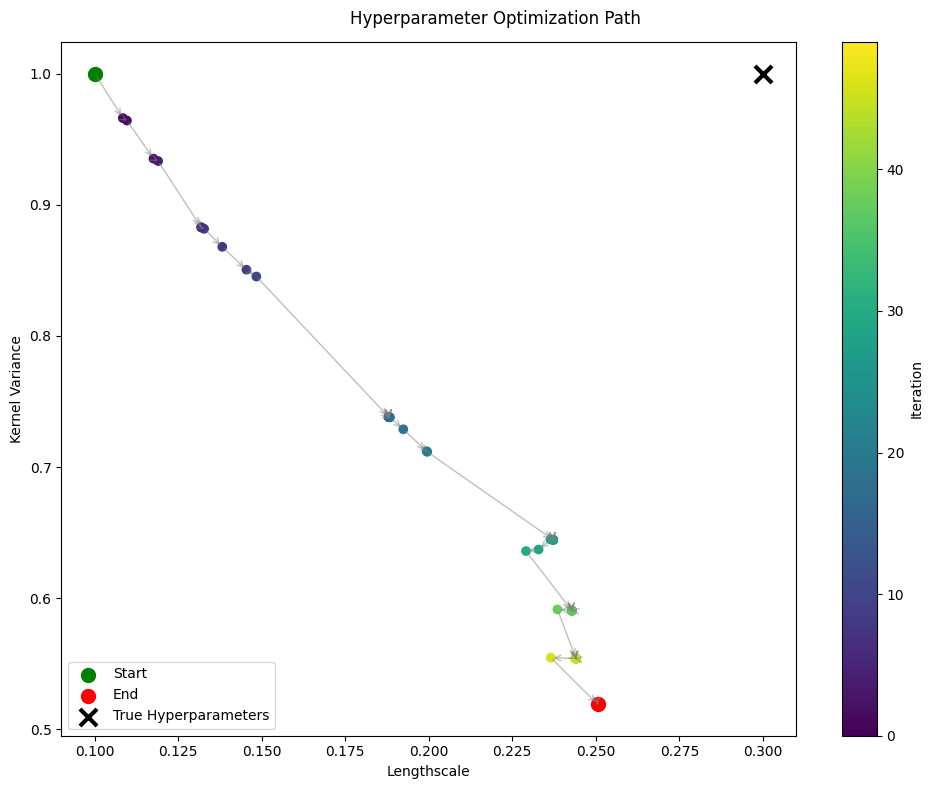

In [37]:
# Plot the hyperparameter optimization path in 2D
import matplotlib.pyplot as plt

# Extract hyperparameter history from the model's training log
training_log = model.training_log[0]
lengthscale_history = training_log['tracked_hyperparameters']['lengthscale']
variance_history = training_log['tracked_hyperparameters']['variance']

# Create a figure for the 2D plot
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Hyperparameter Optimization Path')

# Plot lengthscale versus kernel variance
scatter = ax.scatter(lengthscale_history, variance_history, c=range(len(lengthscale_history)), cmap='viridis')
ax.set_xlabel('Lengthscale')
ax.set_ylabel('Kernel Variance')

# Add colorbar to show iteration progression
cbar = plt.colorbar(scatter)
cbar.set_label('Iteration')

# Add arrows to show direction of optimization
for i in range(len(lengthscale_history)-1):
    ax.annotate('', 
                xy=(lengthscale_history[i+1], variance_history[i+1]),
                xytext=(lengthscale_history[i], variance_history[i]),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

# Mark start and end points
ax.scatter(lengthscale_history[0], variance_history[0], color='green', s=100, label='Start')
ax.scatter(lengthscale_history[-1], variance_history[-1], color='red', s=100, label='End')
# Add true hyperparameters if available
# Assuming the true hyperparameters are the ones used to generate the data
# If you have different true values, replace these with the correct ones


# Plot the true hyperparameters as an X
ax.scatter(true_length_scale, true_variance, 
           marker='x', color='black', s=150, linewidth=3, 
           label='True Hyperparameters')


ax.legend()

plt.tight_layout()
plt.show()


In [44]:
# Time different variance estimation methods
import time

# No variance
start_time = time.time()
mean_no_var, _ = model.fit().predict(x_new, return_variance=False)
no_var_time = time.time() - start_time
print(f"Time without variance: {no_var_time:.4f} seconds")


Time without variance: 0.3516 seconds


In [46]:


# Stochastic variance
start_time = time.time()
hutchinson_probes = 1000
mean, stoch_var = model.predict(x_new, return_variance=True, variance_method="stochastic", hutchinson_probes=hutchinson_probes)
stoch_var_time = time.time() - start_time
print(f"Time with stochastic variance, x_new.shape = {x_new.shape}, {hutchinson_probes} probes: {stoch_var_time:.4f} seconds")




Time with stochastic variance, x_new.shape = torch.Size([1000000, 2]), 1000 probes: 0.4487 seconds


# Later - check on why regular variance is a bit slow

In [ ]:
# Regular variance
start_time = time.time()
mean, var = model.predict(x_new, return_variance=True, variance_method="regular")
reg_var_time = time.time() - start_time
print(f"Time with regular variance, x_new.shape = {x_new.shape}: {reg_var_time:.4f} seconds")

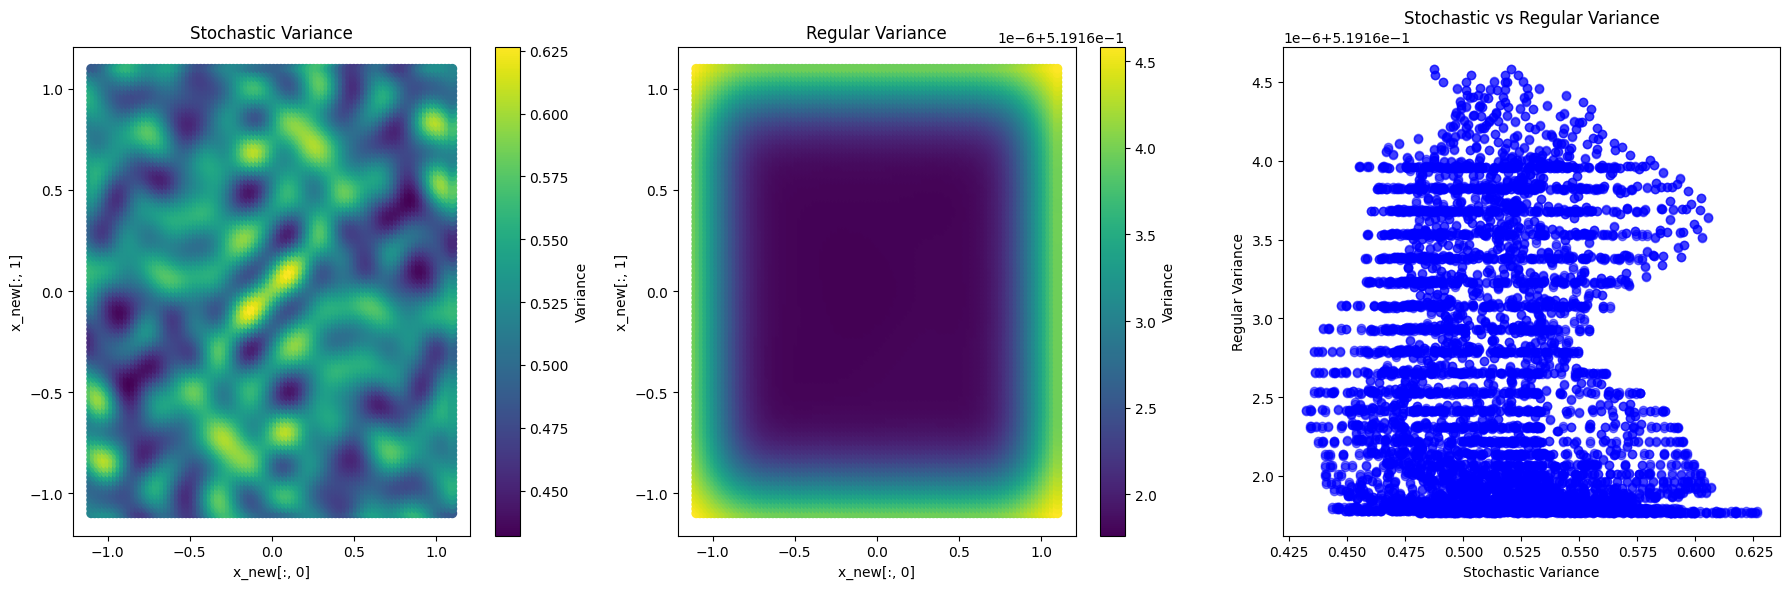

In [41]:
# Subplots for 2D plot of variance with respect to x_new grid for stochastic and regular variance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Stochastic Variance
sc1 = axs[0].scatter(x_new[:, 0].cpu().numpy(), x_new[:, 1].cpu().numpy(), c=stoch_var.cpu().numpy(), cmap='viridis')
axs[0].set_title('Stochastic Variance')
axs[0].set_xlabel('x_new[:, 0]')
axs[0].set_ylabel('x_new[:, 1]')
fig.colorbar(sc1, ax=axs[0], label='Variance')

# Plot for Regular Variance
sc2 = axs[1].scatter(x_new[:, 0].cpu().numpy(), x_new[:, 1].cpu().numpy(), c=var.cpu().numpy(), cmap='viridis')
axs[1].set_title('Regular Variance')
axs[1].set_xlabel('x_new[:, 0]')
axs[1].set_ylabel('x_new[:, 1]')
fig.colorbar(sc2, ax=axs[1], label='Variance')

# Plot for Stochastic vs Regular Variance
sc3 = axs[2].scatter(stoch_var.cpu().numpy(), var.cpu().numpy(), c='blue', alpha=0.5)
axs[2].set_title('Stochastic vs Regular Variance')
axs[2].set_xlabel('Stochastic Variance')
axs[2].set_ylabel('Regular Variance')

plt.tight_layout()
plt.show()


In [42]:
x_new.shape

torch.Size([10000, 2])

In [ ]:
# add plot of fit and true function

if d == 2:

    import plotly.graph_objects as go
    import numpy as np
    from scipy.interpolate import griddata

    # --- Prepare Data for Plotting ---
    # Extract x1, x2 coordinates and mean values from tensors
    x1 = x_new[:, 0].cpu().numpy()
    x2 = x_new[:, 1].cpu().numpy()
    mean_values = mean.cpu().numpy()

    # Create a grid for the surface plot
    x1_grid = np.linspace(x1.min(), x1.max(), 100)
    x2_grid = np.linspace(x2.min(), x2.max(), 100)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)

    # Interpolate mean values onto the grid for smooth surface visualization
    mean_surface = griddata(
        points=(x1, x2), 
        values=mean_values, 
        xi=(X1, X2), 
        method='cubic'
    )

    # --- Create Interactive 3D Plot ---
    fig = go.Figure()

    # Add the mean surface with transparency
    fig.add_trace(go.Surface(
        z=mean_surface,
        x=X1,
        y=X2,
        colorscale='Viridis',
        opacity=0.9,  # Increased opacity for better visibility
        name='EFGP Mean',
        colorbar=dict(
            title=dict(
                text="Mean Value",
                font=dict(size=14)
            ),
            tickfont=dict(size=12)
        )
    ))

    # Add scatter points for the true data with much higher transparency
    # Sample only a subset of points to reduce clutter
    sample_size = min(500, len(x))  # Limit to 500 points max
    indices = np.random.choice(len(x), sample_size, replace=False)
    
    fig.add_trace(go.Scatter3d(
        x=x[indices, 0].cpu().numpy(),
        y=x[indices, 1].cpu().numpy(),
        z=y[indices].cpu().numpy(),
        mode='markers',
        marker=dict(
            size=2,  # Even smaller scatter points
            color='red',
            opacity=0.15,  # Much higher transparency
            symbol='circle'
        ),
        name='True Data (Sample)'
    ))

    # --- Update Layout for Better Visualization ---
    fig.update_layout(
        scene=dict(
            aspectmode='manual',
            aspectratio=dict(x=1.5, y=1.5, z=1), # Make x and y dimensions wider relative to z
            xaxis=dict(
                title=dict(
                    text='x₁',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            yaxis=dict(
                title=dict(
                    text='x₂',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            zaxis=dict(
                title=dict(
                    text='Mean/True Data',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.2)  # Adjusted camera angle for better view
            )
        ),
        title=dict(
            text='EFGP Mean and True Data',
            font=dict(size=18),
            x=0.5,  # Center the title
            xanchor='center'
        ),
        legend=dict(
            x=0.8,
            y=0.9,
            font=dict(size=12),
            bgcolor='rgba(255, 255, 255, 0.8)',  # Add a semi-transparent background
            bordercolor='black',
            borderwidth=1
        ),
        margin=dict(l=0, r=0, t=50, b=0),  # Reduce margins for a cleaner look
        width=800,  # Increase figure width
        height=600   # Increase figure height
    )

    # Display the plot
    fig.show()


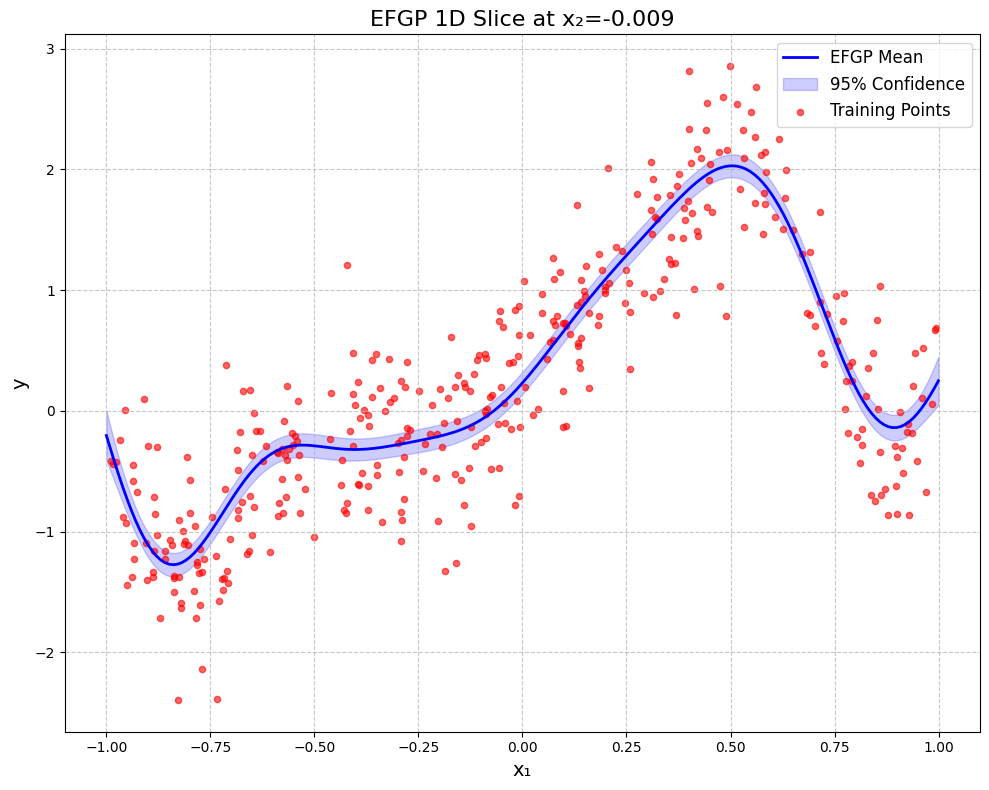

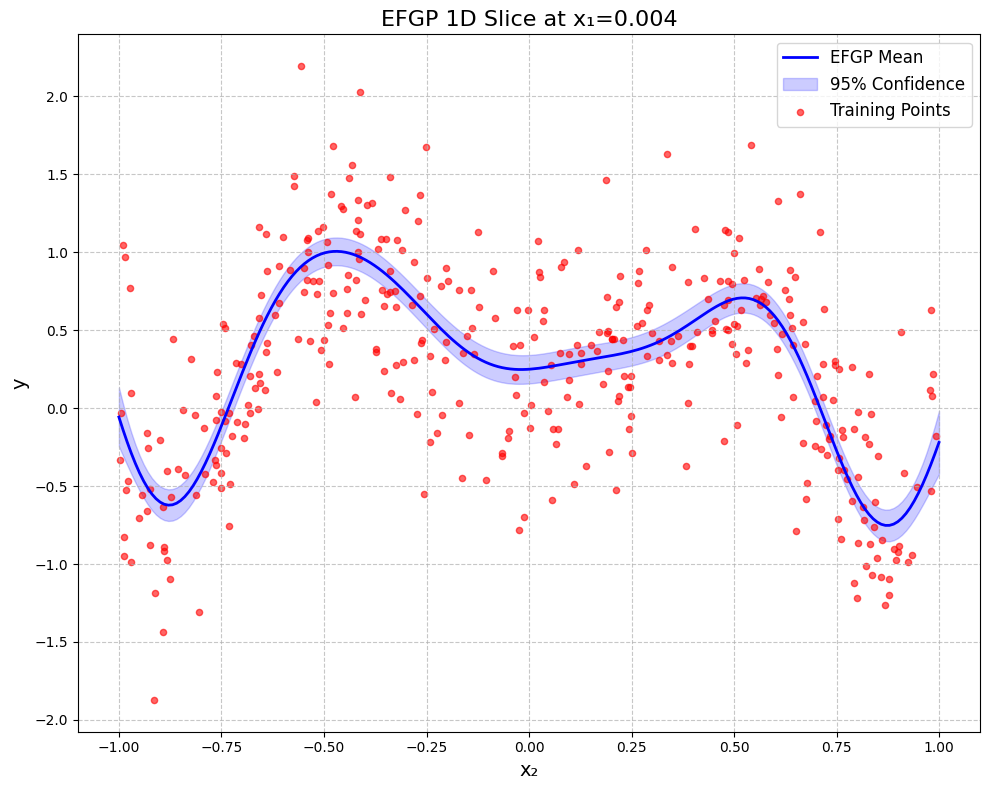

In [ ]:
# Plot mean fit versus training points in 1D slice
def plot_1d_slice(model, x_train, y_train, dimension=0, slice_value=None, num_points=200):
    """
    Plot a 1D slice of the model's predictions against training points.
    
    Parameters:
    -----------
    model : EFGPND
        The fitted EFGP model
    x_train : torch.Tensor
        Training input points
    y_train : torch.Tensor
        Training target values
    dimension : int
        The dimension to vary (0 for x₁, 1 for x₂)
    slice_value : float
        The value to fix for the other dimension. If None, uses the median.
    num_points : int
        Number of points to use for the slice
    """
    # Determine dimensions
    fixed_dim = 1 - dimension  # The dimension to keep fixed
    
    # If slice_value is not provided, use the median of the fixed dimension
    if slice_value is None:
        slice_value = x_train[:, fixed_dim].median().item()
    
    # Get the range for the varying dimension
    min_val = x_train[:, dimension].min().item()
    max_val = x_train[:, dimension].max().item()
    
    # Create points along the slice
    x_slice = torch.linspace(min_val, max_val, num_points, device=x_train.device)
    
    # Create full input points for prediction
    x_pred = torch.zeros((num_points, 2), device=x_train.device)
    x_pred[:, dimension] = x_slice
    x_pred[:, fixed_dim] = slice_value
    
    # Get predictions
    mean_pred, var_pred = model.predict(x_pred, return_variance=True,variance_method="regular",)
    # mean_pred, var_pred = model.predict(x_pred, return_variance=True,variance_method="stochastic",hutchinson_probes=1000)
    
    # Find training points close to the slice
    tolerance = (max_val - min_val) / 50  # Adjust tolerance as needed
    mask = torch.abs(x_train[:, fixed_dim] - slice_value) < tolerance
    x_train_slice = x_train[mask, dimension]
    y_train_slice = y_train[mask]
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot the mean prediction
    plt.plot(x_slice.cpu().numpy(), mean_pred.cpu().numpy(), 'b-', linewidth=2, label='EFGP Mean')
    
    # Plot confidence intervals (±2 standard deviations)
    std_pred = torch.sqrt(var_pred)
    plt.fill_between(
        x_slice.cpu().numpy(),
        (mean_pred - 2 * std_pred).cpu().numpy(),
        (mean_pred + 2 * std_pred).cpu().numpy(),
        color='b', alpha=0.2, label='95% Confidence'
    )
    
    # Plot training points
    plt.scatter(x_train_slice.cpu().numpy(), y_train_slice.cpu().numpy(), 
                c='r', s=20, alpha=0.6, label='Training Points')
    
    # Add labels and title
    dim_label = "x₁" if dimension == 0 else "x₂"
    fixed_dim_label = "x₂" if dimension == 0 else "x₁"
    plt.xlabel(dim_label, fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title(f'EFGP 1D Slice at {fixed_dim_label}={slice_value:.3f}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

# Create a 1D slice plot for the x₁ dimension
fig1 = plot_1d_slice(model, x, y, dimension=0)
plt.show()

# Create a 1D slice plot for the x₂ dimension
fig2 = plot_1d_slice(model, x, y, dimension=1)
plt.show()


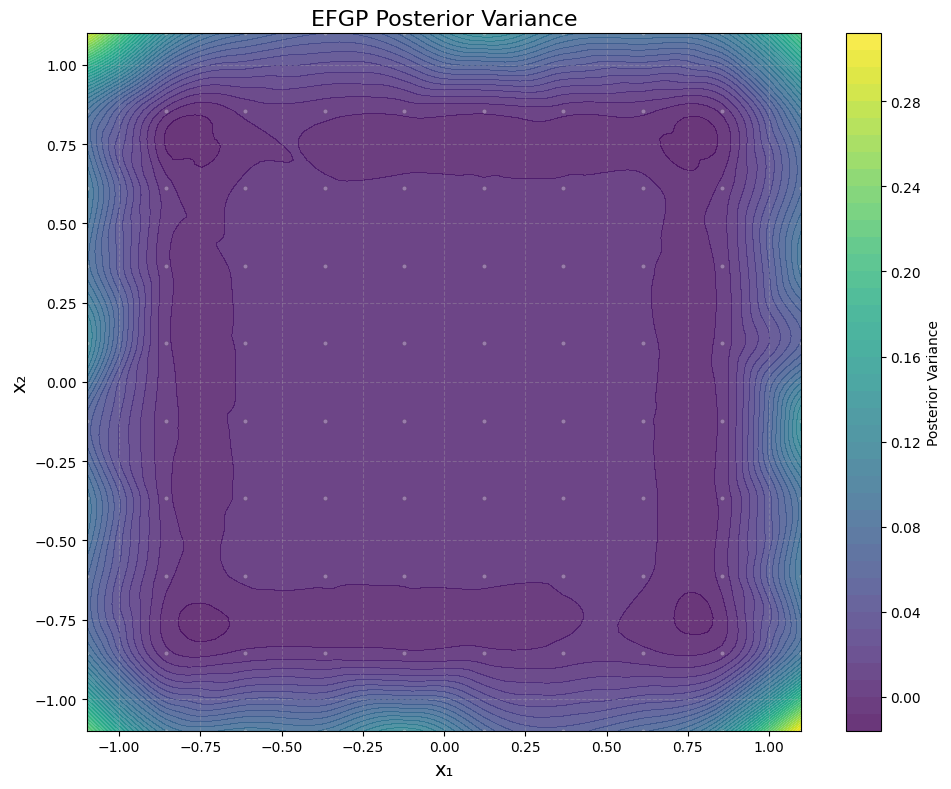

In [58]:
# Use x_new directly for visualization
x_grid = x_new

# Compute posterior mean and variance on the grid
mean_grid, var_grid = model.predict(x_grid, return_variance=True, variance_method="stochastic", hutchinson_probes=100)

# Extract x and y coordinates for plotting
x_coords = x_grid[:, 0].numpy()
y_coords = x_grid[:, 1].numpy()

# Create a grid for interpolation
n_grid = 100  # Number of points in each dimension
xi = np.linspace(min(x_coords), max(x_coords), n_grid)
yi = np.linspace(min(y_coords), max(y_coords), n_grid)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate the variance values onto the regular grid
zi_grid = griddata((x_coords, y_coords), var_grid.numpy(), (xi_grid, yi_grid), method='cubic')

# Create a filled contour plot of the variance
plt.figure(figsize=(10, 8))
contour = plt.contourf(xi_grid, yi_grid, zi_grid, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(contour, label='Posterior Variance')

# Optionally overlay the original points
plt.scatter(x_coords, y_coords, c='white', s=10, alpha=0.3, edgecolors='k', linewidths=0.2)

plt.xlabel('x₁', fontsize=14)
plt.ylabel('x₂', fontsize=14)
plt.title('EFGP Posterior Variance', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Alternative: Create an interactive 3D surface plot with Plotly
import plotly.graph_objects as go
import numpy as np

# Create a 3D surface plot
fig = go.Figure(data=[
    go.Surface(
        x=xi_grid,
        y=yi_grid,
        z=zi_grid,
        colorscale='Viridis',
        opacity=0.9,
        colorbar=dict(title='Variance')
    )
])

# Optionally add the original points as scatter
fig.add_trace(go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=var_grid.numpy(),
    mode='markers',
    marker=dict(
        size=3,
        color='white',
        opacity=0.5
    ),
    showlegend=False
))

fig.update_layout(
    title='EFGP Posterior Variance',
    scene=dict(
        xaxis_title='x₁',
        yaxis_title='x₂',
        zaxis_title='Variance',
        camera=dict(eye=dict(x=1.25, y=1.25, z=1))
    ),
    width=800,
    height=600
)

fig.show()


In [59]:
# import pandas as pd
# usa_df = pd.DataFrame(dat)

In [60]:
# x_unscaled = dat['x']

In [61]:
# x_unscaled.shape

In [62]:
# x_new.shape

In [63]:
# """
# Visualize temperature readings on a USA map with both observed data and posterior mean estimates.

# $ pip install cartopy matplotlib pandas
# (↳  On Ubuntu: apt-get install libproj-dev proj-data proj-bin libgeos-dev)
# """

# import pandas as pd
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import numpy as np
# from matplotlib.colors import Normalize
# from scipy.interpolate import griddata

# # Extract latitude and longitude from x_unscaled
# lats = x_unscaled[:, 0]  # First column contains latitudes
# lons = x_unscaled[:, 1]  # Second column contains longitudes
# observed_values = dat['y']   # The 'y' values represent the observed data

# # Check data dimensions to avoid mismatch errors
# print(f"Data dimensions: lats={len(lats)}, lons={len(lons)}, observed_values={len(observed_values)}")

# # ---------------------------------------------------------------------
# # Create a single map with both observed data and posterior contours
# # ---------------------------------------------------------------------
# fig = plt.figure(figsize=(13, 6.5))

# # Create a single plot
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(
#     central_longitude=-95, central_latitude=35))

# # Set map extent to cover continental USA
# ax.set_extent([-125, -66.5, 24.5, 49.5], crs=ccrs.PlateCarree())

# # Add map features with higher contrast background
# ax.coastlines(resolution="50m", linewidth=0.5)
# ax.add_feature(cfeature.LAND, facecolor="#f0f0f0")  # Lighter gray for better contrast
# ax.add_feature(cfeature.OCEAN, facecolor="#e6f3ff")  # Light blue for ocean
# ax.add_feature(cfeature.BORDERS, linewidth=0.3)
# ax.add_feature(cfeature.STATES, linewidth=0.2)
# ax.add_feature(cfeature.RIVERS, linewidth=0.2, edgecolor='#6baed6')  # Blue rivers

# # Get value range for colormap
# min_val = observed_values.min()
# max_val = observed_values.max()

# # Create a colormap with hot temps as bright red and cool temps as blue
# cmap = plt.cm.coolwarm  # Using coolwarm: blue for cool, red for hot
# norm = Normalize(vmin=min_val, vmax=max_val)

# # Ensure all arrays have the same length
# if len(observed_values) == len(lats) and len(observed_values) == len(lons):
#     # Plot observed data as points
#     sc = ax.scatter(
#         lons, lats,
#         c=observed_values,
#         s=20,                          # slightly larger marker size
#         cmap=cmap, norm=norm,
#         transform=ccrs.PlateCarree(),
#         alpha=1.0,                     # full opacity for better visibility
#         linewidths=0.8,                # thicker outline
#         edgecolors='white',            # white outline for better contrast
#         zorder=3,                      # ensure points are on top
#         label='Observed Data'
#     )
    
#     # Create a grid for interpolation and contour plotting
#     grid_resolution = 100
#     lon_min, lon_max = lons.min(), lons.max()
#     lat_min, lat_max = lats.min(), lats.max()
    
#     grid_lon = np.linspace(lon_min, lon_max, grid_resolution)
#     grid_lat = np.linspace(lat_min, lat_max, grid_resolution)
    
#     mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)
    
#     # Interpolate posterior mean values onto the grid
#     posterior_mean = mean
#     points = np.column_stack((lons, lats))
#     grid_mean = griddata(points, posterior_mean, (mesh_lon, mesh_lat), method='cubic')
    
#     # Plot contours of the posterior mean with higher contrast
#     contour = ax.contourf(
#         mesh_lon, mesh_lat, grid_mean,
#         levels=15,
#         cmap=cmap, norm=norm,
#         transform=ccrs.PlateCarree(),
#         alpha=0.8,                     # slightly higher alpha for better visibility
#         zorder=2
#     )
    
#     # Add contour lines for better readability
#     contour_lines = ax.contour(
#         mesh_lon, mesh_lat, grid_mean,
#         levels=8,                      # fewer levels for clarity
#         colors='white',                # white lines stand out on the colormap
#         linewidths=0.5,
#         transform=ccrs.PlateCarree(),
#         zorder=2.5                     # above the filled contours but below points
#     )
    
#     # Add a colorbar with improved styling
#     cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.04,
#                       fraction=0.05, extend="both")
#     cbar.set_label("Temperature Values", fontsize=12, weight='bold')
#     cbar.ax.tick_params(labelsize=10)
    
#     # Add a legend to distinguish between observed points and posterior contours
#     from matplotlib.lines import Line2D
#     legend_elements = [
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
#                markersize=8, label='Observed Data (Hot)', markeredgecolor='white'),
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
#                markersize=8, label='Observed Data (Cool)', markeredgecolor='white'),
#         Line2D([0], [0], color='red', lw=4, label='Hot Temperature Contours'),
#         Line2D([0], [0], color='blue', lw=4, label='Cool Temperature Contours')
#     ]
#     ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)
    
#     ax.set_title("Temperature Data with Posterior Mean Contours", fontsize=14, weight="bold")
    
#     plt.tight_layout()
#     plt.show()
# else:
#     print(f"Data length mismatch: lats={len(lats)}, lons={len(lons)}, observed_values={len(observed_values)}")


In [64]:
# """
# Visualize temperature readings on a California map with both observed data and posterior mean estimates.

# $ pip install cartopy matplotlib pandas
# (↳  On Ubuntu: apt-get install libproj-dev proj-data proj-bin libgeos-dev)
# """

# import pandas as pd
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import numpy as np
# from matplotlib.colors import Normalize
# from scipy.interpolate import griddata

# # Extract latitude and longitude from x_unscaled
# lats = x_unscaled[:, 0]  # First column contains latitudes
# lons = x_unscaled[:, 1]  # Second column contains longitudes
# observed_values = dat['y']   # The 'y' values represent the observed data

# # Check data dimensions to avoid mismatch errors
# print(f"Data dimensions: lats={len(lats)}, lons={len(lons)}, observed_values={len(observed_values)}")

# # ---------------------------------------------------------------------
# # Create a single map with both observed data and posterior contours for California
# # ---------------------------------------------------------------------
# fig = plt.figure(figsize=(13, 6.5))

# # Create a single plot with California-centered projection
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(
#     central_longitude=-120, central_latitude=37))

# # Set map extent to cover California
# ax.set_extent([-124.5, -114, 32.5, 42], crs=ccrs.PlateCarree())

# # Add map features with higher contrast background
# ax.coastlines(resolution="10m", linewidth=0.8)  # Higher resolution for California
# ax.add_feature(cfeature.LAND, facecolor="#f0f0f0")  # Lighter gray for better contrast
# ax.add_feature(cfeature.OCEAN, facecolor="#e6f3ff")  # Light blue for ocean
# ax.add_feature(cfeature.BORDERS, linewidth=0.3)
# ax.add_feature(cfeature.STATES, linewidth=0.5)  # Thicker state lines
# ax.add_feature(cfeature.RIVERS, linewidth=0.3, edgecolor='#6baed6')  # Blue rivers

# # Get value range for colormap
# min_val = observed_values.min()
# max_val = observed_values.max()

# # Create a colormap with hot temps as bright red and cool temps as blue
# cmap = plt.cm.coolwarm  # Using coolwarm: blue for cool, red for hot
# norm = Normalize(vmin=min_val, vmax=max_val)

# # Ensure all arrays have the same length
# if len(observed_values) == len(lats) and len(observed_values) == len(lons):
#     # Filter data to only include California points
#     # California bounding box: longitude -124.5 to -114, latitude 32.5 to 42
#     ca_mask = ((lons >= -124.5) & (lons <= -114) & 
#                (lats >= 32.5) & (lats <= 42))
    
#     ca_lons = lons[ca_mask]
#     ca_lats = lats[ca_mask]
#     ca_values = observed_values[ca_mask]
#     ca_posterior_mean = mean[ca_mask] if len(mean) == len(observed_values) else None
    
#     # Plot observed data as points
#     sc = ax.scatter(
#         ca_lons, ca_lats,
#         c=ca_values,
#         s=30,                          # larger marker size for California focus
#         cmap=cmap, norm=norm,
#         transform=ccrs.PlateCarree(),
#         alpha=1.0,                     # full opacity for better visibility
#         linewidths=0.8,                # thicker outline
#         edgecolors='white',            # white outline for better contrast
#         zorder=3,                      # ensure points are on top
#         label='Observed Data'
#     )
    
#     # Create a grid for interpolation and contour plotting
#     grid_resolution = 100
#     lon_min, lon_max = ca_lons.min(), ca_lons.max()
#     lat_min, lat_max = ca_lats.min(), ca_lats.max()
    
#     grid_lon = np.linspace(lon_min, lon_max, grid_resolution)
#     grid_lat = np.linspace(lat_min, lat_max, grid_resolution)
    
#     mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)
    
#     # Interpolate posterior mean values onto the grid
#     points = np.column_stack((ca_lons, ca_lats))
#     grid_mean = griddata(points, ca_posterior_mean if ca_posterior_mean is not None else ca_values, 
#                          (mesh_lon, mesh_lat), method='cubic')
    
#     # Plot contours of the posterior mean with higher contrast
#     contour = ax.contourf(
#         mesh_lon, mesh_lat, grid_mean,
#         levels=15,
#         cmap=cmap, norm=norm,
#         transform=ccrs.PlateCarree(),
#         alpha=0.8,                     # slightly higher alpha for better visibility
#         zorder=2
#     )
    
#     # Add contour lines for better readability
#     contour_lines = ax.contour(
#         mesh_lon, mesh_lat, grid_mean,
#         levels=8,                      # fewer levels for clarity
#         colors='white',                # white lines stand out on the colormap
#         linewidths=0.5,
#         transform=ccrs.PlateCarree(),
#         zorder=2.5                     # above the filled contours but below points
#     )
    
#     # Add a colorbar with improved styling
#     cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.04,
#                       fraction=0.05, extend="both")
#     cbar.set_label("Temperature Values", fontsize=12, weight='bold')
#     cbar.ax.tick_params(labelsize=10)
    
#     # Add a legend to distinguish between observed points and posterior contours
#     from matplotlib.lines import Line2D
#     legend_elements = [
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
#                markersize=8, label='Observed Data (Hot)', markeredgecolor='white'),
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
#                markersize=8, label='Observed Data (Cool)', markeredgecolor='white'),
#         Line2D([0], [0], color='red', lw=4, label='Hot Temperature Contours'),
#         Line2D([0], [0], color='blue', lw=4, label='Cool Temperature Contours')
#     ]
#     # Place legend outside the plot to the right
#     ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5), 
#               framealpha=0.9, fontsize=10)
    
#     ax.set_title("California Temperature Data with Posterior Mean Contours", fontsize=14, weight="bold")
    
#     # Adjust layout to make room for the legend
#     plt.tight_layout(rect=[0, 0, 0.85, 1])
#     plt.show()
# else:
#     print(f"Data length mismatch: lats={len(lats)}, lons={len(lons)}, observed_values={len(observed_values)}")
